# Brain Tumor Detector

## Get and Load Dataset

In [147]:
!pip install --upgrade --no-cache-dir gdown

In [148]:
!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=0efb7e63-bb29-462b-9204-63303e443fc8
To: /kaggle/working/brain_tumor.zip
100%|█████████████████████████████████████████| 156M/156M [00:01<00:00, 121MB/s]


In [149]:
!unzip -q brain_tumor.zip

replace Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [152]:
ls -l

total 152148
drwxr-xr-x 6 root root      4096 Jan 19 11:17 Testing/
drwxr-xr-x 6 root root      4096 Jan 19 11:17 Training/
-rw-r--r-- 1 root root 155791278 Jan 19 14:03 brain_tumor.zip


In [153]:
!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 81 not upgraded.


In [154]:
!tree --dirsfirst --filelimit 4 ./Training/ #just to see folder structures, run only on linux systems like colab

./Training/
|-- glioma  [1321 entries exceeds filelimit, not opening dir]
|-- meningioma  [1339 entries exceeds filelimit, not opening dir]
|-- notumor  [1595 entries exceeds filelimit, not opening dir]
`-- pituitary  [1457 entries exceeds filelimit, not opening dir]

4 directories, 0 files


In [155]:
!tree --dirsfirst --filelimit 4 ./Testing/ #just to see folder structures, run only on linux systems like colab

./Testing/
|-- glioma  [300 entries exceeds filelimit, not opening dir]
|-- meningioma  [306 entries exceeds filelimit, not opening dir]
|-- notumor  [405 entries exceeds filelimit, not opening dir]
`-- pituitary  [300 entries exceeds filelimit, not opening dir]

4 directories, 0 files


## Load Dependencies

In [156]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.13.0


## Utility functions to create dataset generators

In [158]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions


In [159]:
prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [160]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10,
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [161]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [162]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(2569).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [163]:
from tensorflow.keras import layers
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

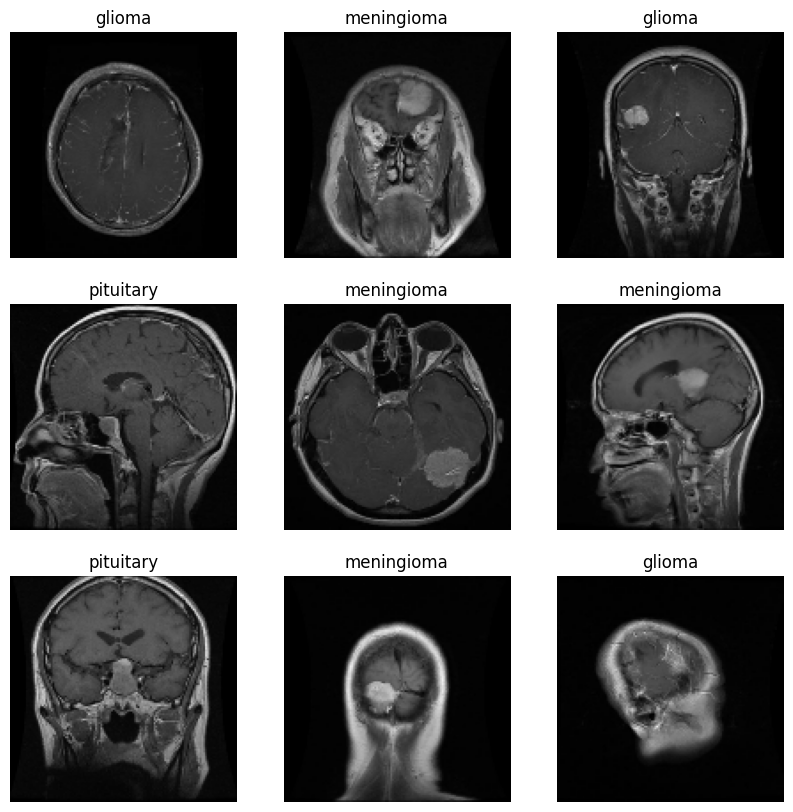

In [164]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

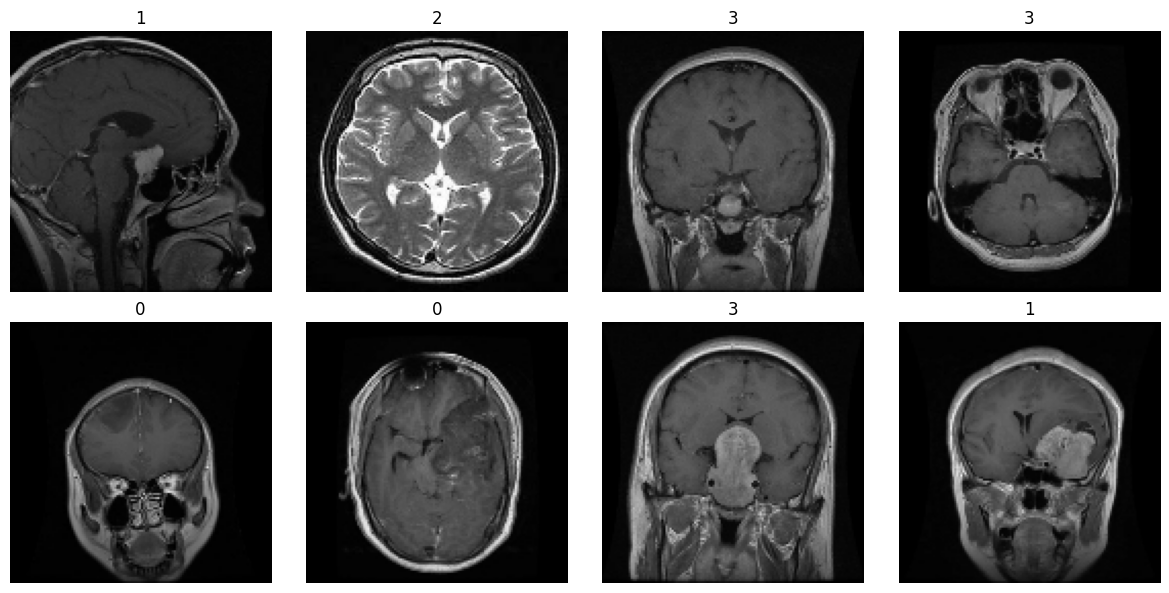

In [165]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

In [166]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [167]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.93823534


In [198]:
from tensorflow.keras.models import Sequential
num_classes = 4

base_model = Sequential([

  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128, 128, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Dropout(0.2),

  layers.Flatten(),

  layers.Dense(256, activation='selu'),

  layers.Dense(num_classes, activation='softmax')

])

In [199]:
base_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [205]:
base_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 conv2d_38 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 64, 64, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 32, 32, 64)      

In [202]:
epochs=40
history = base_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
143/143 [==============================] - 2s 16ms/step - loss: 0.5419 - accuracy: 0.7842 - val_loss: 0.4929 - val_accuracy: 0.8074
Epoch 2/40
143/143 [==============================] - 2s 15ms/step - loss: 0.3849 - accuracy: 0.8549 - val_loss: 0.4121 - val_accuracy: 0.8476
Epoch 3/40
143/143 [==============================] - 2s 15ms/step - loss: 0.2738 - accuracy: 0.8980 - val_loss: 0.2382 - val_accuracy: 0.9238
Epoch 4/40
143/143 [==============================] - 2s 15ms/step - loss: 0.2081 - accuracy: 0.9228 - val_loss: 0.2023 - val_accuracy: 0.9370
Epoch 5/40
143/143 [==============================] - 2s 15ms/step - loss: 0.1309 - accuracy: 0.9543 - val_loss: 0.2644 - val_accuracy: 0.9238
Epoch 6/40
143/143 [==============================] - 2s 15ms/step - loss: 0.1233 - accuracy: 0.9593 - val_loss: 0.1528 - val_accuracy: 0.9448
Epoch 7/40
143/143 [==============================] - 2s 15ms/step - loss: 0.0744 - accuracy: 0.9746 - val_loss: 0.1915 - val_accuracy: 0.9387

In [206]:
for layer in base_model.layers:
  print(layer.name, '->', layer.trainable)

rescaling_11 -> True
conv2d_38 -> True
max_pooling2d_38 -> True
conv2d_39 -> True
max_pooling2d_39 -> True
conv2d_40 -> True
max_pooling2d_40 -> True
conv2d_41 -> True
max_pooling2d_41 -> True
conv2d_42 -> True
max_pooling2d_42 -> True
dropout_12 -> True
flatten_9 -> True
dense_28 -> True
dense_29 -> True


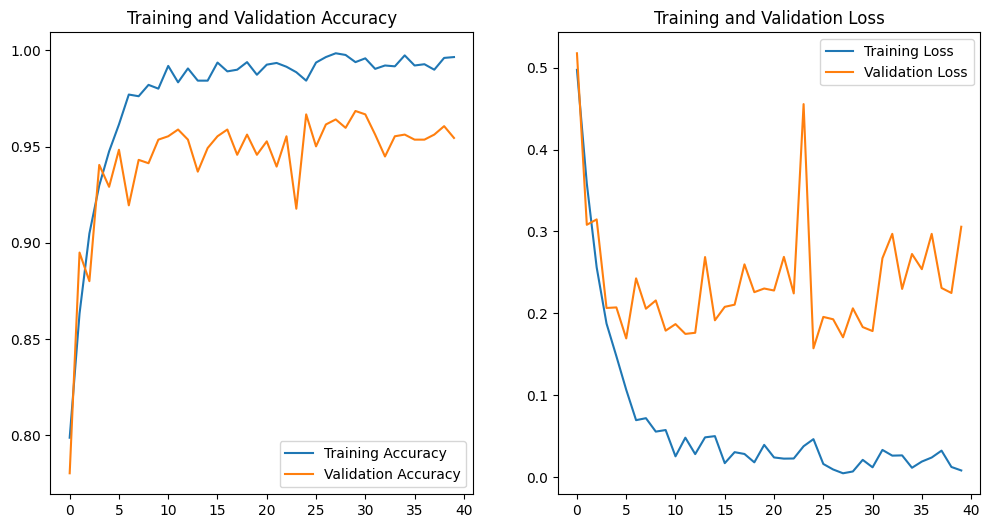

In [174]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [224]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn import metrics
import seaborn as sns

In [225]:
def create_test_report(labels, predictions):
    """Function to create whole test report uses create_res_labels function and plot_confusion_matrix function"""
    
    df_res_labels = create_res_labels_df(labels, predictions)
    print(df_res_labels.head)
    
    print_metric_to_console = False
    lvls=['']
    
    metrics_dict = {}
    
    n_samples = df_res_labels.shape[0]
    print('.'*50)
    print('showing test metrics for {} samples'.format(n_samples))
    print('`'*50)
    
    lvl_metrics_dict = {}
    for lvl in lvls:
        y_tr = df_res_labels['y_true' + lvl]
        y_pre = df_res_labels['y_pred' + lvl]  
    
        lvl_metrics_dict = {}
        
        # Macro / Micro Driven Metrics
        for avg in ['macro', 'micro']:
            
            met_name = 'precision' + ('_'+ avg)    
            res = metrics.precision_score(y_tr, y_pre, average=avg)
            lvl_metrics_dict[met_name] = res
            
            met_name = 'f1' + ('_'+ avg)    
            res = metrics.f1_score(y_tr, y_pre, average=avg)
            lvl_metrics_dict[met_name] = res
            
            met_name = 'recall' + ('_'+ avg)    
            res = metrics.recall_score(y_tr, y_pre, average=avg)
            lvl_metrics_dict[met_name] = res
            
        met_name = 'accuracy'    
        res = metrics.accuracy_score(y_tr, y_pre)
        lvl_metrics_dict[met_name] = res
        
        metrics_dict[lvl] = lvl_metrics_dict
    
    df_test_results = pd.DataFrame(metrics_dict).sort_values(by=lvls, ascending=False)
    df_test_results=df_test_results.reindex(columns=lvls)
    
    print(df_test_results)
    print('- '*70)
    
    plot_confusion_matrix(df_res_labels)
    
    return df_res_labels

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn import metrics
import seaborn as sns## If you want to apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__

In [226]:
IMG_SHAPE = (128, 128, 3,)
model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

In [227]:
image_batch, label_batch = next(iter(train_ds))
image_batch.shape

TensorShape([32, 128, 128, 3])

In [233]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 2048)


In [229]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_10[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [230]:
for layer in model.layers:
  print(layer.name, '->', layer.trainable)

input_10 -> True
conv1_pad -> True
conv1_conv -> True
conv1_bn -> True
conv1_relu -> True
pool1_pad -> True
pool1_pool -> True
conv2_block1_1_conv -> True
conv2_block1_1_bn -> True
conv2_block1_1_relu -> True
conv2_block1_2_conv -> True
conv2_block1_2_bn -> True
conv2_block1_2_relu -> True
conv2_block1_0_conv -> True
conv2_block1_3_conv -> True
conv2_block1_0_bn -> True
conv2_block1_3_bn -> True
conv2_block1_add -> True
conv2_block1_out -> True
conv2_block2_1_conv -> True
conv2_block2_1_bn -> True
conv2_block2_1_relu -> True
conv2_block2_2_conv -> True
conv2_block2_2_bn -> True
conv2_block2_2_relu -> True
conv2_block2_3_conv -> True
conv2_block2_3_bn -> True
conv2_block2_add -> True
conv2_block2_out -> True
conv2_block3_1_conv -> True
conv2_block3_1_bn -> True
conv2_block3_1_relu -> True
conv2_block3_2_conv -> True
conv2_block3_2_bn -> True
conv2_block3_2_relu -> True
conv2_block3_3_conv -> True
conv2_block3_3_bn -> True
conv2_block3_add -> True
conv2_block3_out -> True
conv3_block1_1_

In [231]:
model.trainable = True

In [234]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [235]:
prediction_layer = tf.keras.layers.Dense(4, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [236]:
from tensorflow import keras
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("vertical",
                                                 input_shape=(128,
                                                              128,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [238]:
inputs = tf.keras.Input(shape=IMG_SHAPE)

aug_img = data_augmentation(inputs)

pre_img = tf.keras.applications.resnet.preprocess_input(aug_img)

# important: training=False if you dont want to finetune batchnorm layers
res_model_fm = model(pre_img, training=True)

feature_vecs = tf.keras.layers.GlobalAveragePooling2D()(res_model_fm)

dense1 = tf.keras.layers.Dense(256)(feature_vecs)

drop1 = tf.keras.layers.Dropout(0.2)(dense1)

outputs = tf.keras.layers.Dense(4, activation='softmax')(drop1)

model = tf.keras.Model(inputs, outputs)

In [239]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [240]:
loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

36/36 [==============================] - 3s 41ms/step - loss: 1.8493 - accuracy: 0.2583
initial loss: 1.85
initial accuracy: 0.26


In [191]:
initial_epochs = 40

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/40
143/143 [==============================] - 56s 140ms/step - loss: 0.8095 - accuracy: 0.6919 - val_loss: 0.4466 - val_accuracy: 0.8336
Epoch 2/40
143/143 [==============================] - 19s 132ms/step - loss: 0.4211 - accuracy: 0.8418 - val_loss: 0.3326 - val_accuracy: 0.8713
Epoch 3/40
143/143 [==============================] - 19s 134ms/step - loss: 0.3085 - accuracy: 0.8823 - val_loss: 0.3063 - val_accuracy: 0.8923
Epoch 4/40
143/143 [==============================] - 19s 134ms/step - loss: 0.2472 - accuracy: 0.9053 - val_loss: 0.2753 - val_accuracy: 0.9072
Epoch 5/40
143/143 [==============================] - 19s 132ms/step - loss: 0.2060 - accuracy: 0.9245 - val_loss: 0.2378 - val_accuracy: 0.9116
Epoch 6/40
143/143 [==============================] - 19s 133ms/step - loss: 0.1747 - accuracy: 0.9361 - val_loss: 0.2416 - val_accuracy: 0.9098
Epoch 7/40
143/143 [==============================] - 19s 133ms/step - loss: 0.1663 - accuracy: 0.9398 - val_loss: 0.2125 - val_ac

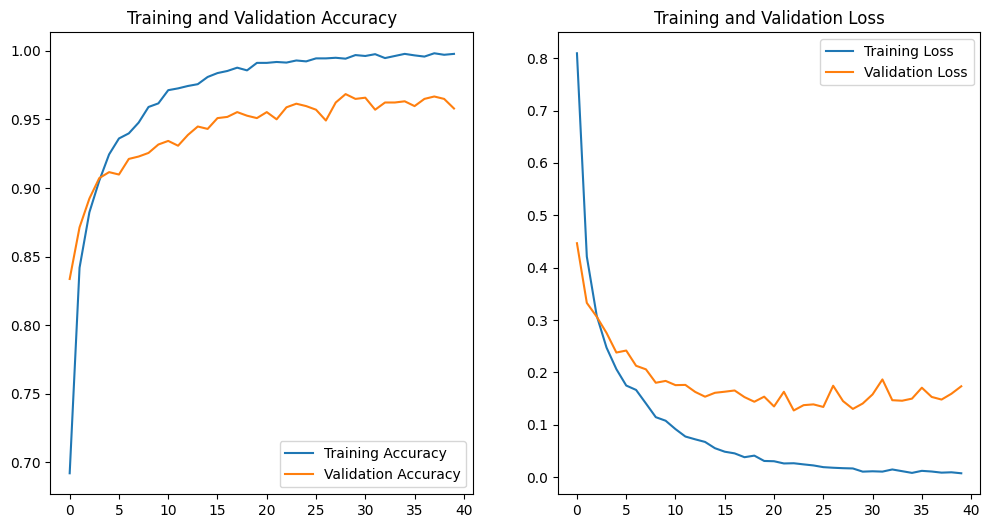

In [192]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 1s 50ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:19,  1.92s/it]

4/4 [==============================] - 0s 43ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:02<00:08,  1.05it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:02<00:05,  1.57it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:02<00:03,  2.06it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:02<00:02,  2.51it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:03<00:01,  2.88it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:03<00:01,  3.18it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:03<00:00,  3.42it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:03<00:00,  3.58it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:04<00:00,  3.73it/s]

1/1 [==============================] - 1s 1s/step


Predicting on Test Data: 100%|██████████| 11/11 [00:05<00:00,  2.05it/s]

<bound method NDFrame.head of       y_true  y_pred
0          2       2
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
1306       1       1
1307       2       2
1308       1       1
1309       1       1
1310       3       3

[1311 rows x 2 columns]>
..................................................
showing test metrics for 1311 samples
``````````````````````````````````````````````````
                         
accuracy         0.959573
f1_micro         0.959573
precision_micro  0.959573
recall_micro     0.959573
precision_macro  0.959219
f1_macro         0.957223
recall_macro     0.956344
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


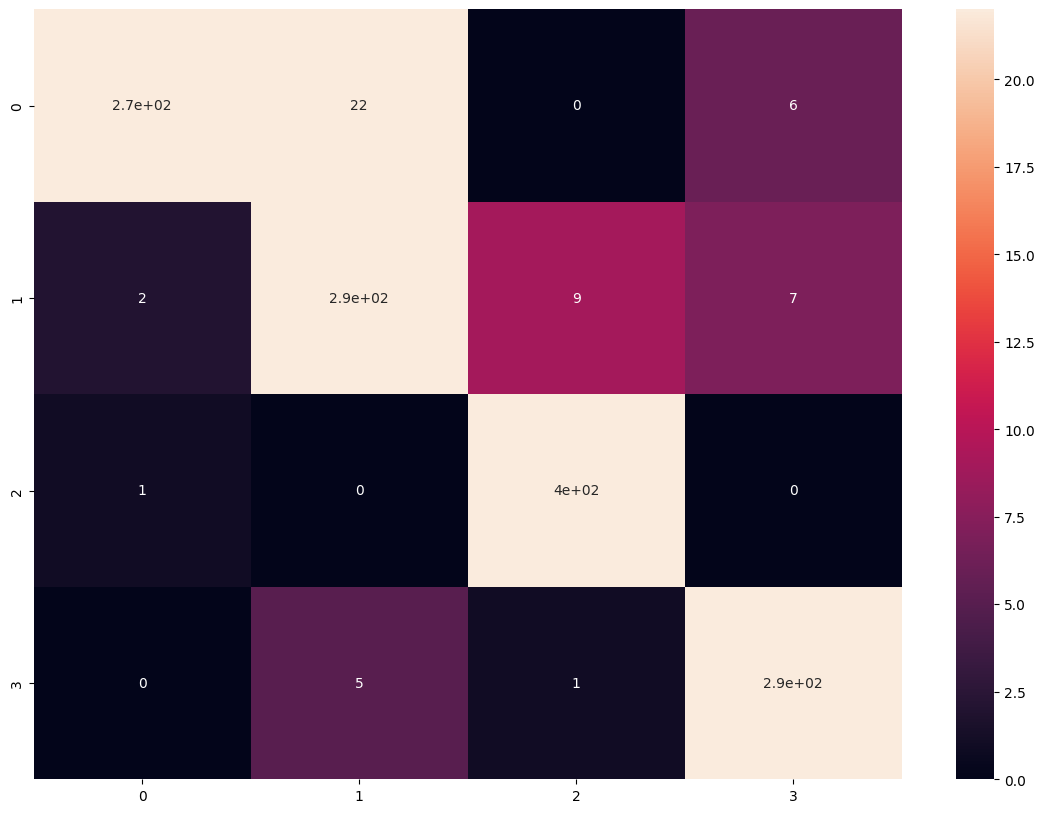

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,y_true,y_pred
0,2,2
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
1306,1,1
1307,2,2
1308,1,1
1309,1,1


In [196]:
y_true, y_pred = eval_model_on_test(model)
create_test_report(y_true, y_pred) 

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:00<00:03,  2.96it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:00<00:02,  3.95it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  5.61it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  6.12it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:01<00:00,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:01<00:00,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:01<00:00,  7.50it/s]

1/1 [==============================] - 0s 22ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:01<00:00,  5.75it/s]

<bound method NDFrame.head of       y_true  y_pred
0          2       2
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
1306       1       1
1307       2       2
1308       1       1
1309       1       1
1310       3       3

[1311 rows x 2 columns]>
..................................................
showing test metrics for 1311 samples
``````````````````````````````````````````````````
                         
accuracy         0.953471
f1_micro         0.953471
precision_micro  0.953471
recall_micro     0.953471
precision_macro  0.951680
f1_macro         0.951301
recall_macro     0.951186
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


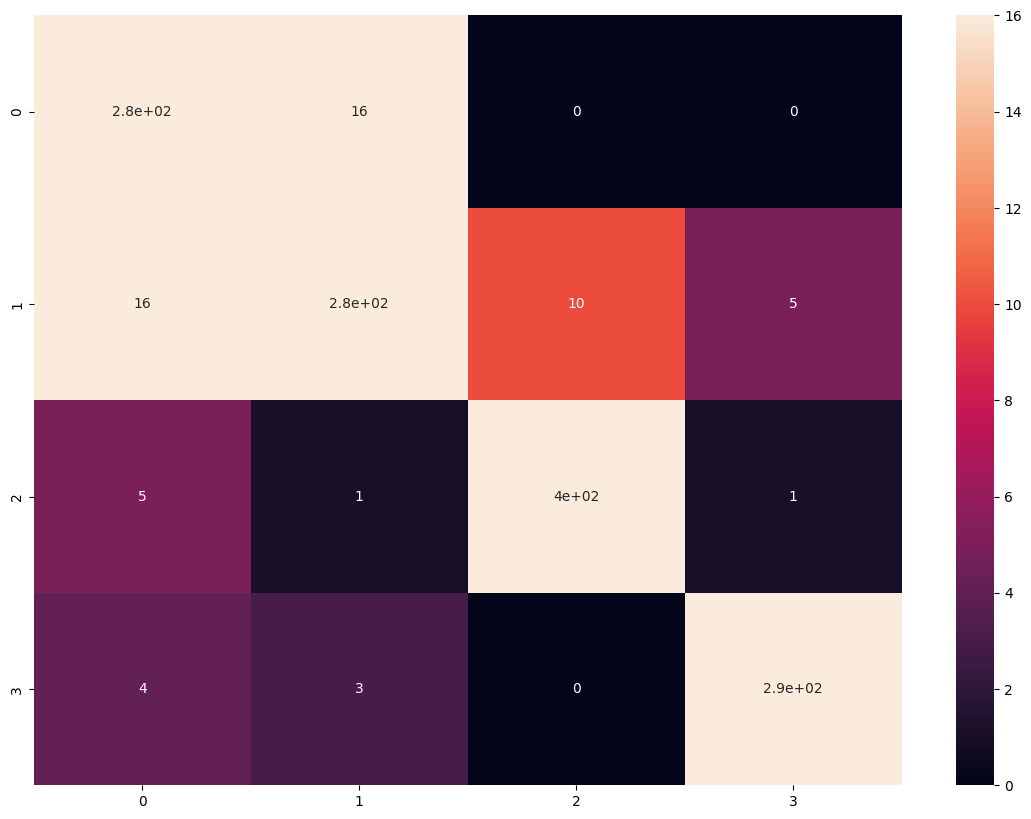

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,y_true,y_pred
0,2,2
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
1306,1,1
1307,2,2
1308,1,1
1309,1,1


In [204]:
y_true_1, y_pred_1 = eval_model_on_test(base_model)
create_test_report(y_true_1, y_pred_1) 